In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from glob import glob1
import os
import pandas as pd
from datetime import datetime
import time

In [2]:
import matplotlib
fontsize = 25
matplotlib.rcParams.update({'font.size': fontsize})
matplotlib.rcParams['lines.linewidth'] = 3
matplotlib.rcParams['font.family']='arial'
params = {'legend.edgecolor': '0',
          'lines.markersize' : 5,
          'legend.borderaxespad': 1.5,
          'legend.fancybox': False,
          'legend.fontsize': fontsize*0.8,
          'legend.framealpha': 0.5,
          'legend.labelspacing': 0.3,
          'legend.markerscale': 1.0,
          'figure.figsize': (10, 8),
         'axes.labelsize': fontsize,
         'axes.titlesize': fontsize,
         'axes.linewidth': 3,
         'axes.xmargin': 0.03,
         'axes.ymargin': 0.03,
         'xtick.direction': 'in',
         'xtick.labelsize': fontsize,
         'xtick.major.pad': 10,
         'xtick.major.size': 10,
         'xtick.major.width': 3,
         'xtick.minor.pad': 10,
         'xtick.minor.size': 5,
         'xtick.minor.visible': True,
         'xtick.minor.width': 2,
         'xtick.top': True,
         'ytick.direction': 'in',
         'ytick.labelsize': fontsize,
         'ytick.major.pad': 10,
         'ytick.major.size': 10,
         'ytick.major.width': 3,
         'ytick.minor.pad': 10,
         'ytick.minor.size': 5,
         'ytick.minor.visible': True,
         'ytick.minor.width': 2,
         'ytick.right': True,}
plt.rcParams.update(params)

# Grafana: Cavity Transmission

In [10]:
def grafana_analysis_general(filename,display_chn=3,isplot=False,issaved=False):
    def convert_dates_to_utc_seconds(timestamp_str):
        t0 = datetime.strptime(timestamp_str, '%Y-%m-%dT%H:%M:%S')
        timeref = datetime(1970,1,1)
        return (t0 - datetime(1970,1,1)).total_seconds()
    
    df = pd.read_csv(filename,sep=';')
    list_of_column_names = df.keys()
    timestamp = df[list_of_column_names[0]].str.replace(',', '.')
    utctime = np.array([convert_dates_to_utc_seconds(timestamp_str=timestamp[j][:timestamp[j].find('+')]) for j in range(len(timestamp))])
    chn0 = np.array(df[list_of_column_names[1]],dtype='float') # traces in V
    return utctime,chn0

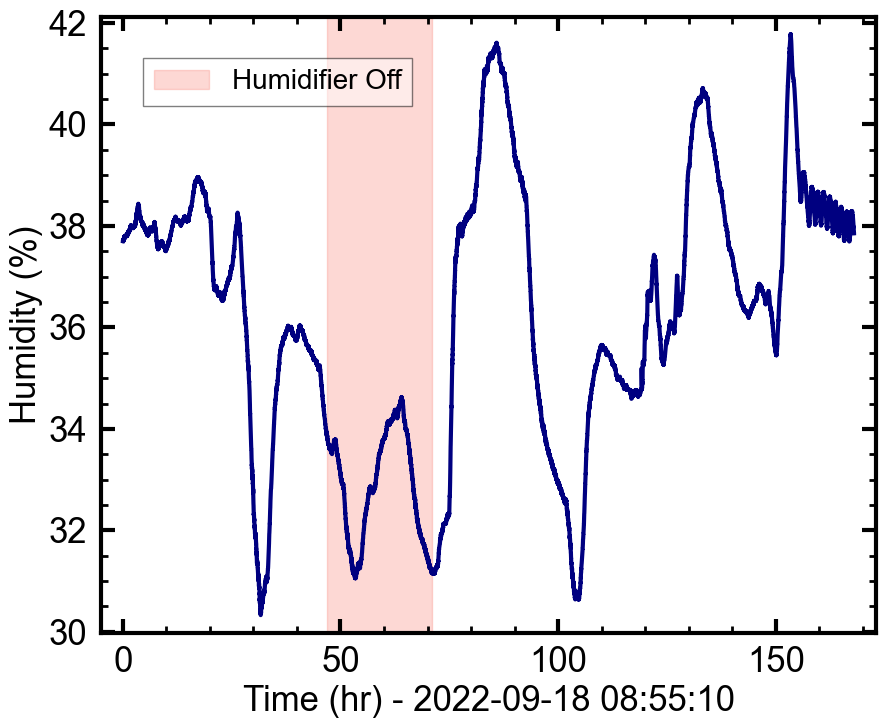

In [38]:
filename = r'C:\Users\zxk94\Documents\grafana_data_export.csv'
utctime,output = grafana_analysis_general(filename)
t0 = datetime.fromtimestamp(utctime[0]-2*3600).strftime( "%Y-%m-%d %H:%M:%S" )
f = plt.figure()
ax = f.add_subplot(111)
ax.plot((utctime-utctime[0])/3600,output,color='navy')
ax.axvspan(47, 71, alpha=0.3, color='salmon',label='Humidifier Off')
ax.legend()
ax.set_xlabel('Time (hr) - %s'%(t0))
ax.set_ylabel('Humidity (%)')
f.savefig(filename[:-4]+'_humidity.png',dpi=100,bbox_inches='tight',facecolor='white')

In [101]:
def grafana_data_output(filename,display_chn=3,isplot=False,issaved=False):
    def convert_dates_to_utc_seconds(timestamp_str):
        t0 = datetime.strptime(timestamp_str, '%Y-%m-%dT%H:%M:%S')
        timeref = datetime(1970,1,1)
        return (t0 - datetime(1970,1,1)).total_seconds()
    
    df = pd.read_csv(filename,sep=';')
    list_of_column_names = df.keys()
    timestamp = df[list_of_column_names[0]].str.replace(',', '.')
    utctime = np.array([convert_dates_to_utc_seconds(timestamp_str=timestamp[j]) for j in range(len(timestamp))])
    chn0 = np.array(df[list_of_column_names[1]],dtype='float') # traces in V
    chn1 = np.array(df[list_of_column_names[2]],dtype='float') # traves in V
    chn2 = np.array(df[list_of_column_names[3]],dtype='float') # traces in V
    chn3 = np.array(df[list_of_column_names[4]],dtype='float') # traces in V
    chn = np.concatenate([chn0,chn1,chn2,chn3]).reshape((4,len(chn0)))
    if isplot:
        f = plt.figure()
        ax  =f.add_subplot(111)
        ax.plot(utctime,chn[int(display_chn)],color='navy')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Voltage (V)')
        if issaved:
            from scipy.io import savemat
            f.savefig(filename[:-4]+'_timeseries.png',dpi=100,bbox_inches='tight',facecolor='white')
            mdic = {"time_in_s": utctime, '729trans': chn[int(display_chn)] }
            savemat(filename[:-4]+'_data.mat',mdic)
            print ('Saved as %s'%(filename[:-4]+'_data.mat'))
            print ('Saved as %s'%(filename[:-4]+'_timeseries.png'))
    return utctime,chn

In [8]:
directory = r'Z:\qfc\users\Armin\grafana_traces'
flst = glob1(directory,'**.csv')
flst

['07042022_grafana_data_export_729transmission.csv']

Saved as Z:\qfc\users\Armin\grafana_traces\07042022_grafana_data_export_729transmission_data.mat
Saved as Z:\qfc\users\Armin\grafana_traces\07042022_grafana_data_export_729transmission_timeseries.png


(1.4, 1.5)

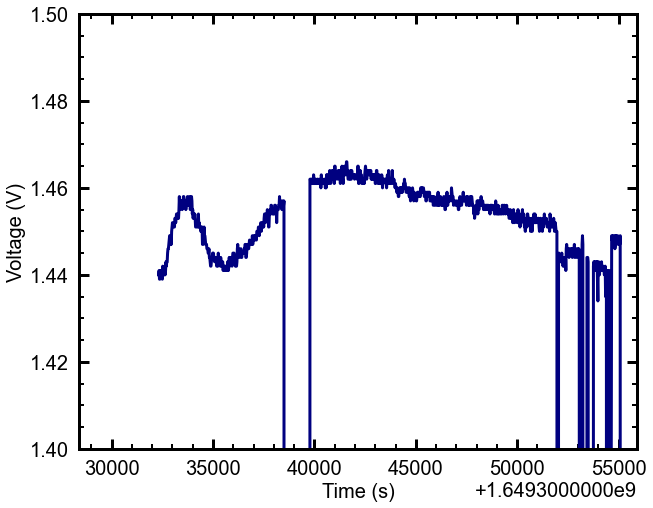

In [9]:
filename = os.path.join(directory,flst[0])
utctime,channel_data = grafana_data_output(filename,display_chn=3,isplot=True,issaved=not False)
plt.ylim([1.4,1.5])

# Beat Center: Plot everything together

In [120]:
class beat_data_analysis:
    def __init__(self, directory,flst,index=0):
        self.flst = flst
        self.directory = directory
        self.beat_centers = []
        self.time_stamps = []
        self.index = index
        self.start_time = datetime(2022, 8, 1, 0, 0,0).timestamp() 
        if self.index!=-1:
            self.extract_data(self.index)
        else:
            for j in range(len(flst)):
                self.extract_data(index=j)
        
    def extract_data(self,index=0):
        print (self.flst[index])
        filename = os.path.join(self.directory,self.flst[index])
        df = pd.read_csv(filename,header=None)
        times = np.array(df[0])
        self.time_initial = times[0]
        corrected_time = times - self.time_initial
        fwhm = np.array(df[1],dtype=float)
        dfwhm = np.array(df[2],dtype=float)
        center = np.array(df[3],dtype=float)
        dcenter = np.array(df[4],dtype=float)
        self.time_zero_str = datetime.fromtimestamp(self.time_initial).strftime( "%Y-%m-%d %H:%M:%S" )
        valid = np.zeros(len(fwhm),dtype='bool')
        for j in range(len(fwhm)):
            if (dfwhm[j]/fwhm[j] < 1e-2) and (fwhm[j]< 350) and dcenter[j]/center[j] < 1e-4:
                valid[j] = True

        self.corrected_time = corrected_time[valid]
        self.corrected_time =self.corrected_time
        self.fwhm = fwhm[valid]
        self.dfwhm = dfwhm[valid]
        self.center =center[valid]
        self.dcenter = dcenter[valid]
        
        self.beat_centers.append(self.center)
        
        self.time_stamps.append(self.corrected_time + self.time_initial)
        if self.start_time==0:
            self.start_time = self.time_initial
        else:
            if self.time_initial<self.start_time:
                self.start_time = self.time_initial
            
    
    def plot_data(self,saved_filename=None):
        import seaborn as sns
        colors = sns.color_palette("Set2")
        f = plt.figure()
        ax  =f.add_subplot(111)
        ax.set_ylabel('Beat Center (kHz)')
        if self.index!=-1:
            
            ax.plot(self.corrected_time/3600,np.array(self.beat_centers).flatten()/1e3,'o',color=colors[0])
            ax.set_xlabel('Time - %s CET (hour)'%self.time_zero_str)
            
        else:
            max_time = 0
            for j in range(len(flst)):
                ax.plot((np.array(self.time_stamps)[j]-self.start_time)/3600/24,np.array(self.beat_centers)[j]/1e3,'o',color=colors[0])
                if max((np.array(self.time_stamps)[j]-self.start_time)/3600/24)>max_time:
                    max_time = max((np.array(self.time_stamps)[j]-self.start_time)/3600/24)
            timestring = datetime.fromtimestamp(self.start_time).strftime( "%Y-%m-%d %H:%M:%S" )
            ax.set_xlabel('Time - %s CET (day)'%timestring )
            ax.set_xlim(left=0)
            # ax.set_xticks(np.arange(0,max_time,24))
            # ax.set_xticklabels(np.arange(0,max_time/24,1))
        if saved_filename is not None:
            print ('Saved as %s'%(directory+'/'+saved_filename+'.png'))
            f.savefig(os.path.join(directory,saved_filename+'.png'),dpi=100,bbox_inches='tight',facecolor='white')

01082022_729spectrum_linewidth_center_fit.txt
02082022_729spectrum_linewidth_center_fit.txt
03082022_729spectrum_linewidth_center_fit.txt
04082022_729spectrum_linewidth_center_fit.txt
05082022_729spectrum_linewidth_center_fit.txt
082022_729spectrum_linewidth_center_fit.txt


C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the n

Saved as Z:\qfc\measurements\general\2022\2022_06_BeatLinears\Logging/August2022_729_BeatCenter.png


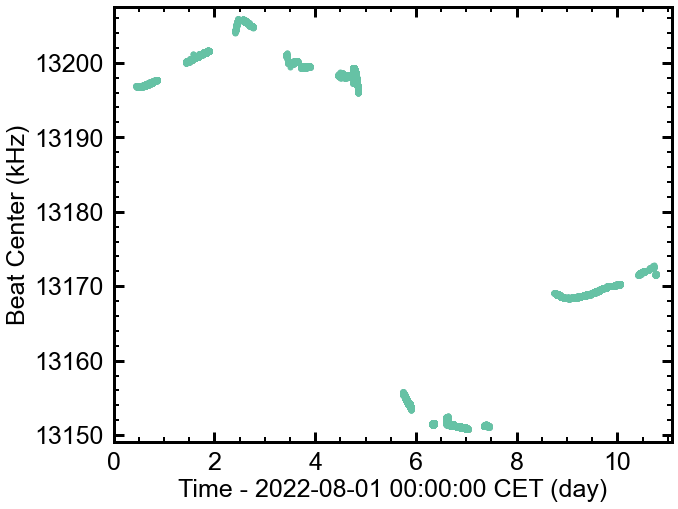

In [123]:
directory = r'Z:\qfc\measurements\general\2022\2022_06_BeatLinears\Logging'
flst = glob1(directory,'*082022_729spectrum_linewidth_center_fit*.txt')
beat_data = beat_data_analysis(directory,flst,index=-1)
beat_data.plot_data(saved_filename='August2022_729_BeatCenter')